In [1]:
print("hello world")

hello world


# Low-Level Interfaces

### There are two low level interfaces that we need to know to be able to apply so that we can identify the differences an can construct things.
1. Lazy Computation (Futures are delayed)
2. Immediate computation (Futures are awaited)

In [ ]:
import dask
import dask.delayed

# Delayed computations are executed lazily evalued at run time until the compute is called
# The delayed decorator is used to create a delayed function
@dask.delayed
def add(x, y):
    return x + y
@dask.delayed
def inc(x):
    return x + 1
@dask.delayed
def dec(x):
    return x - 2


HighLevelGraph with 5 layers.
 0. random_sample-c978cce01e1ff3e93363f5c7c98bd74a
 1. finalize-5a3a2a50-6ae3-4025-9a08-9beb5b8e9adf
 2. inc-6e463905-c96a-4b0f-96f8-691f34419943
 3. dec-e6acd126-a376-4705-b122-132ae3a249a7
 4. add-26bcbeeb-2b68-4b0e-a823-35578f807916



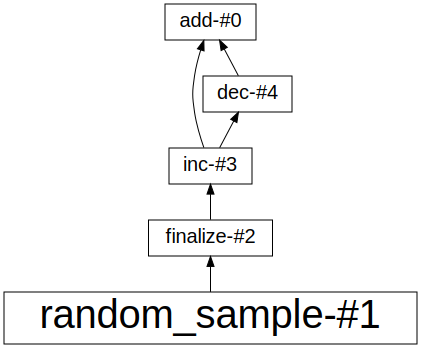

In [4]:
import dask.array as da
a = da.random.random((1000, 1000), chunks=(100, 100))
b = inc(a)
c = dec(b)
d = add(b, c)
# Now let us see the dask and visualize the graph
print(d.dask)
d.dask.visualize()

In [6]:
print(d)
d # This is going to give me a future and not the actualr result

Delayed('add-26bcbeeb-2b68-4b0e-a823-35578f807916')


Delayed('add-26bcbeeb-2b68-4b0e-a823-35578f807916')

In [ ]:
print(list(zip(a[:10, 5].compute(), d.compute()[:10, 5]))) # this will give me actual comptuation for the first 10 rowsand 5th column before and after computation

[(np.float64(0.9316628316363579), np.float64(2.8633256632727155)), (np.float64(0.9152801766163948), np.float64(2.83056035323279)), (np.float64(0.031061670313075274), np.float64(1.0621233406261505)), (np.float64(0.7808725573630645), np.float64(2.561745114726129)), (np.float64(0.23851308819631623), np.float64(1.4770261763926325)), (np.float64(0.9055902595454296), np.float64(2.8111805190908594)), (np.float64(0.6527636051374167), np.float64(2.3055272102748336)), (np.float64(0.8154748964864229), np.float64(2.630949792972846)), (np.float64(0.35295123222342584), np.float64(1.7059024644468517)), (np.float64(0.19653895319945514), np.float64(1.3930779063989105))]


## Setup a Cluster to execute the task immediately

In [20]:
from dask.distributed import Client
client = Client("localhost:8786")
def inc(x):
    return x + 1
def add(x, y):
    return x + y

b = client.submit(inc, a)
c = client.submit(inc, b)
d = client.submit(add, b, c)
e = d.result()
e


dask.array<add, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

## Explore more on cluster and each of its resources

In [23]:
client

<Client: 'tcp://192.168.1.6:8786' processes=3 threads=3, memory=101.41 GiB>

In [24]:
client[0].status

TypeError: 'Client' object is not subscriptable

## Using DASK bags for better computation and grouping computations


**NOTE** : The key here is always to start the computations and maps as if you are dealing only with one system and only one set of data. Abstract away from implementations and try to set the the data as required much later.

In [26]:
import dask.bag as db
# Creating a dask_bag for computations
bag = db.from_sequence([da.random.random((1000, 1000), chunks=(100, 100)) for i in range(3) ])

In [27]:
bag

dask.bag<from_sequence, npartitions=3>

### We can use something like below for direct computation or use 
^dd.compute(bag)^

In [28]:
bag.compute()

[dask.array<random_sample, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>,
 dask.array<random_sample, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>,
 dask.array<random_sample, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>]

In [30]:
bc = db.zip(bag, bag.map(lambda x : x * 10))
bc.dask

HighLevelGraph with 3 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x767c2ff12f60>
 0. from_sequence-83ff9be38e33f79d0b9b685f4ffc717f
 1. lambda-128e468eeca2c1b65398c0c1f844d777
 2. zip-8fe123ee60d6022d058e906781a77223

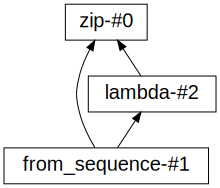

In [31]:
bc.dask.visualize()

In [32]:
bc.compute()

[(dask.array<random_sample, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>,
  dask.array<mul, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>),
 (dask.array<random_sample, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>,
  dask.array<mul, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>),
 (dask.array<random_sample, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>,
  dask.array<mul, shape=(1000, 1000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>)]

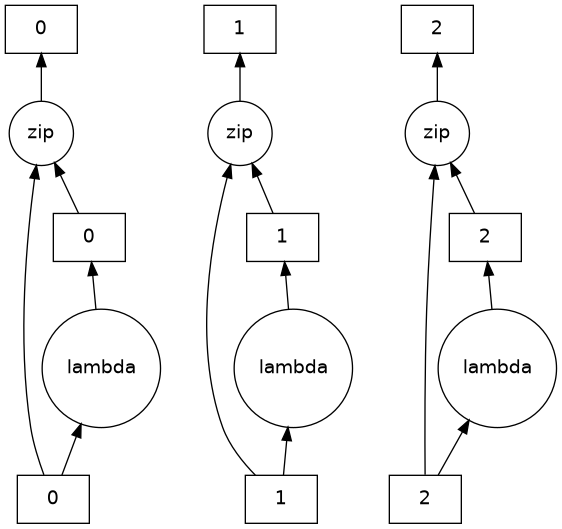

In [33]:
bc.visualize()